## Lab: LeNet in TensorFlow

You're now going to put together everything you've learned and implement the LeNet architecture using TensorFlow. When you get to your next project, remember that LeNet can be a great starting point for your network architecture!

**1. Instructions:**
1. Go to the LeNet with GPU workspace
2. Open the jupyter notebook LeNet-Lab.ipynb
3. Finish off the architecture implementation in the LeNet function. That's the only piece that's missing.
4. Important: Remember to turn off your GPU when not training.

**2. Preprocessing:**

An MNIST image is initially `784` features `(1D)`. If the data is not normalized from `[0, 255]` to `[0, 1]`, normalize it. We reshape this to `(28, 28, 1)` `(3D)`, and pad the image with 0s such that the height and width are 32 (centers digit further). Thus, the input shape going into the first convolutional layer is `32x32x1`.

**3. Specs:**

* **_Convolution layer 1:_** The output shape should be `28x28x6`.
* **_Activation 1:_** Your choice of activation function.
* **_Pooling layer 1:_** The output shape should be `14x14x6`.
* **_Convolution layer 2:_** The output shape should be `10x10x16`.
* **_Activation 2:_** Your choice of activation function.
* **_Pooling layer 2:_** The output shape should be `5x5x16`.
* **_Flatten layer:_** Flatten the output shape of the final pooling layer such that it's `1D` instead of `3D`. The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.
* **_Fully connected layer 1:_** This should have `120` outputs.
* **_Activation 3:_** Your choice of activation function.
* **_Fully connected layer 2:_** This should have `84` outputs.
* **_Activation 4:_** Your choice of activation function.
* **_Fully connected layer 3:_** This should have `10` outputs.


There will be two implementations:
* Raw implementation using **_TensorFlow_**
* Advanced implementation using **_Keras_**



## 1. Load the data

Load the MNIST data, which comes pre-loaded with TensorFlow and check the sanity of the dataset.

In [2]:
from tensorflow.keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

assert(len(x_train) == len(y_train))
assert(len(x_test) == len(y_test))

print()
print("Image Shape: {}".format(x_train[0].shape))
print()
print("Training Set:   {} samples".format(len(x_train)))
print("Test Set:       {} samples".format(len(x_test)))


Image Shape: (28, 28)

Training Set:   60000 samples
Test Set:       10000 samples


In [3]:


# Pad images with 0s
x_train      = np.pad(x_train, ((0,0),(2, 2), (2, 2)))
x_test       = np.pad(x_test, ((0,0),(2, 2), (2, 2)))

print("Updated Image Shape: {}".format(x_train.shape))

Updated Image Shape: (60000, 32, 32)


## 2. Visualize Data
View a sample from the dataset.

5


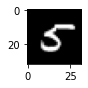

In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(x_train))
image = x_train[index]

plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

In [5]:
import tensorflow as tf

# Use tf.data API to shuffle and batch data.

learning_rate = 0.001
training_steps = 200
batch_size = 256
display_step = 10

conv1_filters = 6
conv2_filters = 16

fc1_units = 120
fc2_units = 84
num_classes = 10

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [6]:
# Store layers weight & bias

# A random value generator to initialize weights.
random_normal = tf.initializers.RandomNormal()

weights = {
    # Conv Layer 1: 5x5 conv, 1 input, 6 filters (MNIST has 1 color channel only).
    'wc1': tf.Variable(random_normal([5, 5, 1, conv1_filters])),
    # Conv Layer 2: 5x5 conv, 6 inputs, 16 filters.
    'wc2': tf.Variable(random_normal([5, 5, conv1_filters, conv2_filters])),
    # FC Layer 1: 5*5*16 inputs, 120 units.
    'wd1': tf.Variable(random_normal([5*5*16, fc1_units])),
    # FC Layer 2: 120 inputs, 84 units.
    'wd2': tf.Variable(random_normal([fc1_units, fc2_units])),    
    # FC Out Layer: 84 inputs, 10 units (total number of classes)
    'out': tf.Variable(random_normal([fc2_units, num_classes]))
}
biases = {
    'bc1': tf.Variable(tf.zeros([conv1_filters])),
    'bc2': tf.Variable(tf.zeros([conv2_filters])),
    'bd1': tf.Variable(tf.zeros([fc1_units])),
    'bd2': tf.Variable(tf.zeros([fc2_units])),
    'out': tf.Variable(tf.zeros([num_classes]))
}

In [7]:
# Create some wrappers for simplicity.
def conv2d(x, W, b, strides=1, padding = 'VALID'):
    # Conv2D wrapper, with bias and relu activation.
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding = padding)
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2, padding = 'VALID'):
    # MaxPool2D wrapper.
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding = padding)

In [8]:
# Create model
def conv_net(x):
    
    # Input shape: [-1, 32, 32, 1]. A batch of 28x28x1 (grayscale) images.
    x = tf.reshape(x, [-1, 32, 32, 1])

    # Convolution Layer. Output shape: [-1, 28, 28, 6].
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    
    # Max Pooling (down-sampling). Output shape: [-1, 14, 14, 6].
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer. Output shape: [-1, 10, 10, 16].
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    
    # Max Pooling (down-sampling). Output shape: [-1, 5, 5, 16].
    conv2 = maxpool2d(conv2, k=2)

    # Reshape conv2 output to fit fully connected layer input, Output shape: [-1, 5*5*16].
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    
    # Fully connected layer, Output shape: [-1, 120].
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    # Apply ReLU to fc1 output for non-linearity.
    fc1 = tf.nn.relu(fc1)

    # Fully connected layer, Output shape: [-1, 84].
    fc2 = tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])
    # Apply ReLU to fc1 output for non-linearity.
    fc2 = tf.nn.relu(fc2)
    
    # Fully connected layer, Output shape: [-1, 10].
    out = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    # Apply softmax to normalize the logits to a probability distribution.
    return tf.nn.softmax(out)

In [9]:
# Cross-Entropy loss function.
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)
    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    # Compute cross-entropy.
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

# ADAM optimizer.
optimizer = tf.optimizers.Adam(learning_rate)

In [10]:
# Optimization process. 
def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        pred = conv_net(x)
        loss = cross_entropy(pred, y)
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = list(weights.values()) + list(biases.values())

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [11]:
# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.    
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = conv_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 10, loss: 576.559631, accuracy: 0.332031
step: 20, loss: 511.812134, accuracy: 0.507812
step: 30, loss: 328.013062, accuracy: 0.664062
step: 40, loss: 220.262421, accuracy: 0.738281
step: 50, loss: 168.687119, accuracy: 0.781250
step: 60, loss: 149.426071, accuracy: 0.816406
step: 70, loss: 109.496140, accuracy: 0.855469
step: 80, loss: 121.977097, accuracy: 0.871094
step: 90, loss: 94.946640, accuracy: 0.902344
step: 100, loss: 98.546021, accuracy: 0.886719
step: 110, loss: 99.779236, accuracy: 0.867188
step: 120, loss: 90.515488, accuracy: 0.906250
step: 130, loss: 59.855827, accuracy: 0.933594
step: 140, loss: 60.316040, accuracy: 0.902344
step: 150, loss: 93.924736, accuracy: 0.917969
step: 160, loss: 66.822144, accuracy: 0.906250
step: 170, loss: 66.674759, accuracy: 0.914062
step: 180, loss: 84.828545, accuracy: 0.902344
step: 190, loss: 52.459991, accuracy: 0.937500
step: 200, loss: 67.655380, accuracy: 0.933594


In [139]:
# Test model on validation set.
pred = conv_net(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.989200


In [140]:
# Visualize predictions.
import matplotlib.pyplot as plt

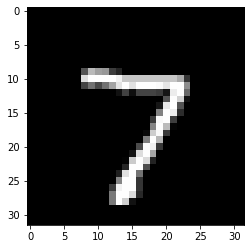

Model prediction: 7


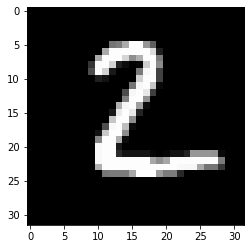

Model prediction: 2


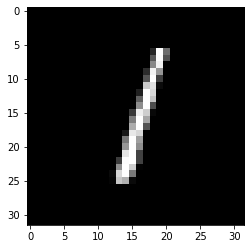

Model prediction: 1


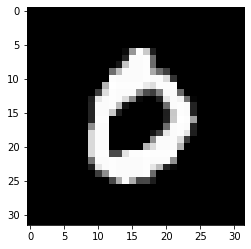

Model prediction: 0


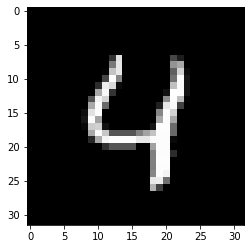

Model prediction: 4


In [142]:
# Predict 5 images from validation set.
n_images = 5
test_images = x_test[:n_images]
predictions = conv_net(test_images)

# Display image and model prediction.
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [32, 32]), cmap='gray')
    plt.show()
    print("Model prediction: %i" % np.argmax(predictions.numpy()[i]))